# Quantile-quantile (QQ) scaled climate projections

In [1]:
import glob
import calendar
import sys
import gc

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
import dask.diagnostics
import cmdline_provenance as cmdprov
import dask
import cmocean
import seaborn as sns
import pandas as pd

sys.path.append('/g/data/wp00/shared_code/qqscale')
import utils

In [2]:
dask.diagnostics.ProgressBar().register()

In [3]:
# Parameters
example_lat = -42.9
example_lon = 147.3
example_month = 6

In [4]:
# Parameters
adjustment_file = "/g/data/wp00/users/dbi599/test_space/tasmin-qdc-adjustment-factors-additive-monthly_day_ACCESS-ESM1-5_historical-ssp370_r1i1p1f1_19950101-20141231_20350101-20641231.nc"
qq_file = "/g/data/wp00/users/dbi599/test_space/tasmin-qdc-additive-monthly-infileq_day_AGCD-ACCESS-ESM1-5_ssp370_r1i1p1f1_20350101-20641231.nc"
example_lat = -42.9
example_lon = 147.3
example_month = 5
hist_units = "K"
ref_units = "K"
target_units = "C"
output_units = "C"
hist_var = "tasmin"
ref_var = "tasmin"
target_var = "tmin"
hist_files = "/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/tasmin/gn/latest/tasmin_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_19500101-19991231.nc /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/tasmin/gn/latest/tasmin_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_20000101-20141231.nc"
ref_files = "/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/tasmin/gn/latest/tasmin_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20150101-20641231.nc /g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/tasmin/gn/latest/tasmin_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20650101-21001231.nc"
target_files = "/g/data/xv83/agcd-csiro/tmin/daily/tmin_AGCD-CSIRO_r005_19100101-20220405_daily_space-chunked.zarr"
hist_time_bounds = "1995-01-01 2014-12-31"
ref_time_bounds = "2035-01-01 2064-12-31"
target_time_bounds = "1990-01-01 2019-12-31"


In [5]:
hist_files = hist_files.split()
ref_files = ref_files.split()
target_files = target_files.split()

hist_time_bounds = hist_time_bounds.split()
ref_time_bounds = ref_time_bounds.split()
target_time_bounds = target_time_bounds.split()

In [6]:
point_selection = {'lat': example_lat, 'lon': example_lon}

## Read data

In [7]:
ds_target = utils.read_data(
    target_files,
    target_var,
    time_bounds=target_time_bounds,
    input_units=target_units,
    output_units=output_units
)

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [8]:
da_target = ds_target[target_var].sel(point_selection, method='nearest')
da_target = da_target.drop(['lat', 'lon'])
da_target = da_target.compute()

[########################################] | 100% Completed |  0.1s


In [9]:
da_target

<xarray.DataArray 'tmin' (time: 10957)>
array([14.251953 ,  8.171875 , 13.982422 , ..., 10.7265625, 12.9765625,
       11.176758 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T09:00:00 ... 2019-12-31T09:00:00
Attributes:
    analysis_time:              2018-08-16 23:47:23 UTC
    analysis_version_number:    2.01
    cell_methods:               time: minimum
    frequency:                  daily
    length_scale_for_analysis:  250.0
    long_name:                  Daily minimum air temperature
    source:                     Interpolated surface observations
    standard_name:              air_temperature
    units:                      C

In [10]:
ds_hist = utils.read_data(
    hist_files,
    hist_var,
    time_bounds=hist_time_bounds,
    input_units=hist_units,
    output_units=output_units,
)

In [11]:
da_hist = ds_hist[hist_var].sel(point_selection, method='nearest')
da_hist = da_hist.drop(['lat', 'lon'])
da_hist = da_hist.compute()

[########################################] | 100% Completed |  6.1s


In [12]:
ds_ref = utils.read_data(
    ref_files,
    ref_var,
    time_bounds=ref_time_bounds,
    input_units=ref_units,
    output_units=output_units,
)

In [13]:
da_ref = ds_ref[ref_var].sel(point_selection, method='nearest')
da_ref = da_ref.drop(['lat', 'lon'])
da_ref = da_ref.compute()

[########################################] | 100% Completed |  8.9s


## Perform QQ-scaling

In [14]:
QM = sdba.EmpiricalQuantileMapping.train(
    da_ref, da_hist, nquantiles=100, group="time.month", kind="+"
)

In [15]:
QM.ds

<xarray.Dataset>
Dimensions:    (quantiles: 100, month: 12)
Coordinates:
  * quantiles  (quantiles) float32 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    af         (month, quantiles) float32 1.226 1.058 1.143 ... 1.081 0.7904
    hist_q     (month, quantiles) float32 11.18 11.73 11.87 ... 18.01 18.91
Attributes:
    group:               time.month
    group_compute_dims:  ['time']
    group_window:        1
    _xclim_adjustment:   {"py/object": "xclim.sdba.adjustment.EmpiricalQuanti...
    adj_params:          EmpiricalQuantileMapping(group=Grouper(add_dims=[], ...

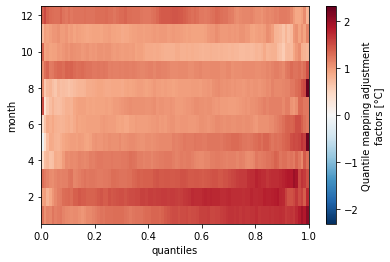

In [16]:
QM.ds['af'].plot()

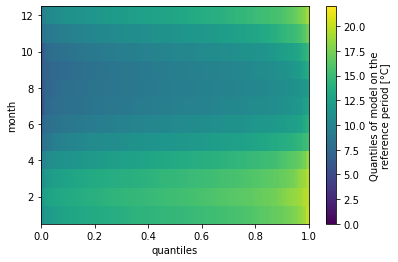

In [18]:
QM.ds['hist_q'].plot(vmin=0, vmax=22, cmap='viridis')
plt.show()

In [19]:
def get_quantiles(da, quantiles, timescale='monthly'):
    """Get quantiles.
    Required because sdba.EmpiricalQuantileMapping.train only
    outputs hist_q and not others like ref_q.    
    """

    if timescale == 'monthly':
        months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        q_list = []
        for month in months:
            mth = sdba.nbutils.quantile(da[da['time'].dt.month == month], quantiles, ['time'])
            q_list.append(mth)
        da_q = xr.concat(q_list, dim='month')
        da_q.coords['month'] = months
        #da_q = da_q.transpose('quantiles', 'month')
    elif timescale == 'annual':
        da_q = nbutils.quantile(da, quantiles, ['time'])
        #da_q = da_q.transpose('quantiles', 'lat', 'lon')
    else:
        raise ValueError('Invalid timescale: {timescale}')
        
    da_q.attrs['standard_name'] = 'Quantiles'
    da_q.attrs['long_name'] = 'Quantiles'

    return da_q

In [20]:
QM.ds['hist_q'].values = get_quantiles(da_target, QM.ds['quantiles'].values)

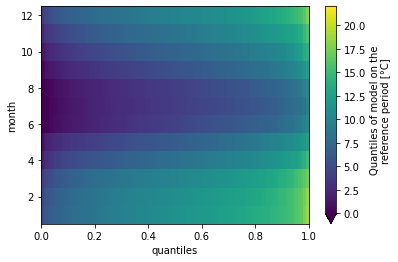

In [21]:
QM.ds['hist_q'].plot(vmin=0, vmax=22, cmap='viridis')
plt.show()

In [22]:
da_qq = QM.adjust(da_target, extrapolation="constant", interp="nearest")

## Check results

In [23]:
df_target = da_target.to_dataframe().reset_index()

In [28]:
df_target

,time,tmin
0,1990-01-01 09:00:00,14.251953
1,1990-01-02 09:00:00,8.171875
2,1990-01-03 09:00:00,13.982422
3,1990-01-04 09:00:00,9.332031
4,1990-01-05 09:00:00,6.551758
...,...,...
10952,2019-12-27 09:00:00,8.306641
10953,2019-12-28 09:00:00,12.636719
10954,2019-12-29 09:00:00,10.726562
10955,2019-12-30 09:00:00,12.976562


In [25]:
df_qq = da_qq.to_dataframe().reset_index()

In [31]:
df = df_target.copy()
df = df.rename(columns={target_var: f'orig_{target_var}'})
df[f'new_{target_var}'] = df_qq['scen']
df['af'] = df[f'new_{target_var}'] - df[f'orig_{target_var}']
df['month'] = df['time'].dt.month.values
df

,time,orig_tmin,new_tmin,af,month
0,1990-01-01 09:00:00,14.251953,15.926384,1.674431,1
1,1990-01-02 09:00:00,8.171875,9.193930,1.022055,1
2,1990-01-03 09:00:00,13.982422,15.671309,1.688887,1
3,1990-01-04 09:00:00,9.332031,10.617530,1.285499,1
4,1990-01-05 09:00:00,6.551758,7.778354,1.226596,1
...,...,...,...,...,...
10952,2019-12-27 09:00:00,8.306641,9.580531,1.273890,12
10953,2019-12-28 09:00:00,12.636719,13.728474,1.091755,12
10954,2019-12-29 09:00:00,10.726562,12.058845,1.332282,12
10955,2019-12-30 09:00:00,12.976562,14.106457,1.129894,12


In [32]:
month_df = df[df['month'] == example_month].sort_values(f'orig_{target_var}', ascending=False)
month_df

,time,orig_tmin,new_tmin,af,month
5603,2005-05-05 09:00:00,14.577148,16.841309,2.264160,5
5602,2005-05-04 09:00:00,14.317383,16.581543,2.264160,5
4511,2002-05-09 09:00:00,13.126953,15.391112,2.264159,5
2678,1997-05-02 09:00:00,13.107422,15.371581,2.264159,5
6703,2008-05-09 09:00:00,12.697266,14.961425,2.264159,5
...,...,...,...,...,...
4160,2001-05-23 09:00:00,0.607422,0.478903,-0.128519,5
1589,1994-05-09 09:00:00,0.306641,0.178122,-0.128519,5
135,1990-05-16 09:00:00,-0.023438,-0.151956,-0.128519,5
7447,2010-05-23 09:00:00,-0.083008,-0.211526,-0.128519,5


In [34]:
month_df['af'] = month_df['af'].round(4)

In [35]:
counts = month_df['af'].value_counts()
counts

1.2493    13
1.2129    13
0.9490    13
1.3202    13
1.2064    12
          ..
0.9816     6
1.0236     6
1.5375     6
1.0467     6
1.0534     5
Name: af, Length: 100, dtype: int64

In [42]:
qcut = pd.qcut(month_df['orig_tmin'], 100, np.arange(1, 101))

In [43]:
qcut.value_counts()

38    12
51    11
11    11
25    11
63    11
      ..
12     8
21     8
16     7
71     7
55     7
Name: orig_tmin, Length: 100, dtype: int64

The quantile binning performed by xclim gives a slightly different result than pandas qcut.